In [24]:
import os, sys
if '..' not in sys.path:
    sys.path.append('..')
    os.chdir('..')

import yaml, torch
import matplotlib.pyplot as plt
import pandas as pd
import torch

import torchvision.transforms as transforms
# from torchvision.transforms import v2
from sklearn.manifold import TSNE

from src.data_manager import init_data
from src.msn_train import init_model

In [25]:
VALIDATION = True
directory = 'checkpoint/msn-complete-br-data' 

with open(os.path.join(directory, "params-precipitation-exp-2.yaml"), 'r') as y_file:
    params = yaml.load(y_file, Loader=yaml.FullLoader)

In [ ]:
rand_transform = transforms.Compose([
        transforms.RandomResizedCrop(128, scale=(0.5, 1.0)),
        transforms.Normalize(
            params['data']['norm_means'], #'Tmin', 'Tmax',
            params['data']['norm_stds'])
    ])


(unsupervised_loader, unsupervised_sampler) = init_data(
    transform=rand_transform,
    batch_size=8,
    surf_vars=params['data']['surf_vars'],
    static_vars=params['data']['static_vars'],
    lat_lim=params['data']['lat_limit'], lon_lim=params['data']['lon_limit'],
    adj_prep_balance=True,
    split_val = True
    # dataset_samples=1000
)

# images, _ = next(iter(unsupervised_loader))
# fig, axes = plt.subplots(1, 8, figsize=(20, 7))

# for i in range(8):
#     axes[i].imshow(images[i][0], cmap='coolwarm')
#     axes[i].axis("off")

In [ ]:
# Create the encoder and load the latest checkpoint

target_encoder = init_model(
    device = "cuda:0",
    model_name = params['meta']['model_name'],
    use_bn = params['meta']['use_bn'],
    hidden_dim = params['meta']['hidden_dim'],
    output_dim = params['meta']['output_dim'],
    drop_path_rate = params['meta']['drop_path_rate'],
)

print(params['logging']['folder'])


latest_checkpoint =  params['logging']['write_tag'] + "-latest.pth.tar"
# other_checkpoint = 'precipitation-exp-1-ep275.pth.tar'

checkpoint = torch.load(os.path.join(params['logging']['folder'],latest_checkpoint), map_location='cpu')

target_encoder.load_state_dict(checkpoint['target_encoder'], strict=False)
target_encoder.eval()

prot = checkpoint['prototypes'].to("cuda:0")
prot = torch.nn.functional.normalize(prot)
prot.shape

INFO:root:VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (fc): Sequent

/tmp/ipykernel_310785/3588666745.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(params['logging']['folder'],latest_checkpoint), ma

torch.Size([30, 128])

In [ ]:
from tqdm import tqdm

# Encode the images with progress bar
E = torch.empty(0, params['meta']['output_dim']).to("cuda:0")
F = torch.empty(0, prot.shape[0]).to("cuda:0")
L = torch.empty(0).to("cuda:0")

with torch.no_grad():
    for img, lab in tqdm(unsupervised_loader.dataset, desc="Encoding"):
        img = img.unsqueeze(0).to("cuda:0")
        enc = target_encoder(img)
        enc = torch.nn.functional.normalize(enc)
        E = torch.cat((E, enc), 0)
        F = torch.cat((F, enc @ prot.T), 0)
        L = torch.cat((L, lab.unsqueeze(0).to("cuda:0")), 0)

print(E.shape, F.shape, L.shape)

Encoding: 100%|██████████| 22358/22358 [02:39<00:00, 140.52it/s]

torch.Size([22358, 128]) torch.Size([22358, 30]) torch.Size([22358])


In [ ]:
if VALIDATION:
    # Encode the images with progress bar
    E_val = torch.empty(0, params['meta']['output_dim']).to("cuda:0")
    F_val = torch.empty(0, prot.shape[0]).to("cuda:0")

    with torch.no_grad():
        for img in tqdm(unsupervised_loader.dataset.validation_imgs, desc="Encoding"):
            img = rand_transform(img)
            img = img.unsqueeze(0).to("cuda:0")
            enc = target_encoder(img)
            enc = torch.nn.functional.normalize(enc)
            E_val = torch.cat((E_val, enc), 0)
            F_val = torch.cat((F_val, enc @ prot.T), 0)

    print(E_val.shape, F_val.shape)

    data = torch.cat((E.cpu(), E_val.cpu(), prot.cpu()), dim=0).numpy()

    # Apply TSNE
    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(data)

    # Separate the results for prototypes and latent points
    tsne_E = tsne_results[:E.shape[0]]
    tsne_Eval = tsne_results[E.shape[0]:E.shape[0]+E_val.shape[0]]
    tsne_prot = tsne_results[E.shape[0]+E_val.shape[0]:]

else:
    data = torch.cat((E.cpu(), prot.cpu()), dim=0).numpy()

    # Apply TSNE
    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(data)

    # Separate the results for prototypes and latent points
    tsne_E = tsne_results[:E.shape[0]]
    tsne_prot = tsne_results[E.shape[0]:]

Encoding: 100%|██████████| 732/732 [00:05<00:00, 145.29it/s]


torch.Size([732, 128]) torch.Size([732, 30])


/tmp/ipykernel_310785/1213877318.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tsne_E[:, 0], tsne_E[:, 1],  cmap='hsv', label='Latent Points', s=0.2)


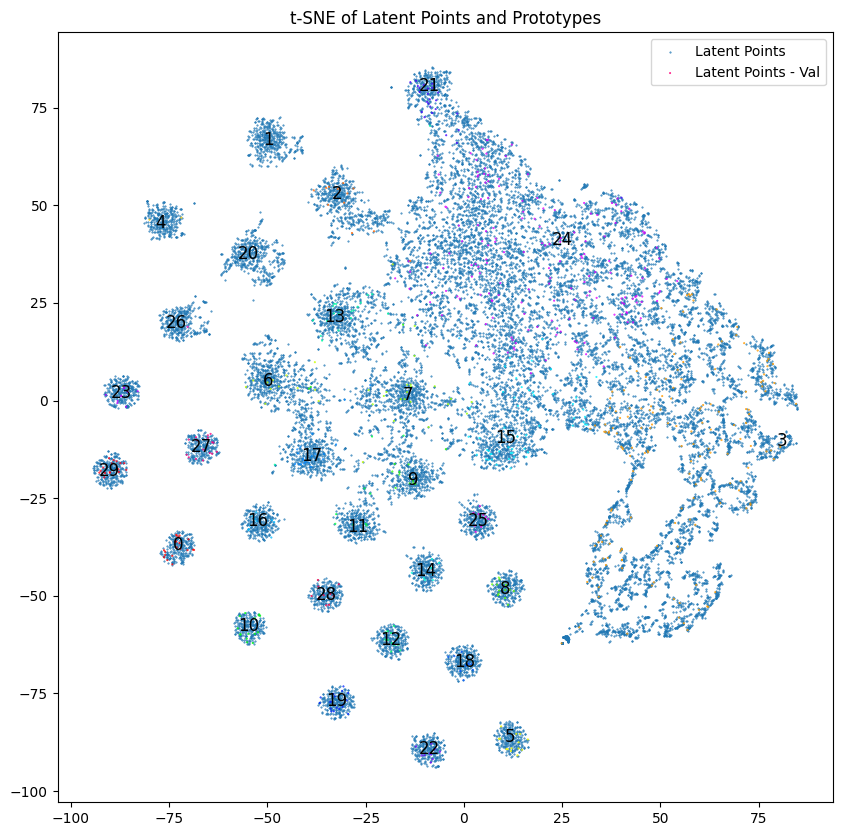

In [ ]:
# Plot the TSNE results

plt.figure(figsize=(10, 10))
if VALIDATION:
    cluster_labels = F_val.argmax(axis=1).cpu().numpy()
    plt.scatter(tsne_E[:, 0], tsne_E[:, 1],  cmap='hsv', label='Latent Points', s=0.2)
    plt.scatter(tsne_Eval[:, 0], tsne_Eval[:, 1], c= cluster_labels, cmap='hsv', label='Latent Points - Val', s=0.2)
else:
    cluster_labels = F.argmax(axis=1).cpu().numpy()
    plt.scatter(tsne_E[:, 0], tsne_E[:, 1], c= cluster_labels, cmap='hsv', label='Latent Points', s=0.2)
# plt.scatter(tsne_prot[:, 0], tsne_prot[:, 1], c='black', label='Prototypes', marker='.')
for i, (x, y) in enumerate(tsne_prot):
    plt.text(x, y, i, color='black', fontsize=12, ha='center', va='center')

plt.legend()
plt.title("t-SNE of Latent Points and Prototypes")
plt.show()

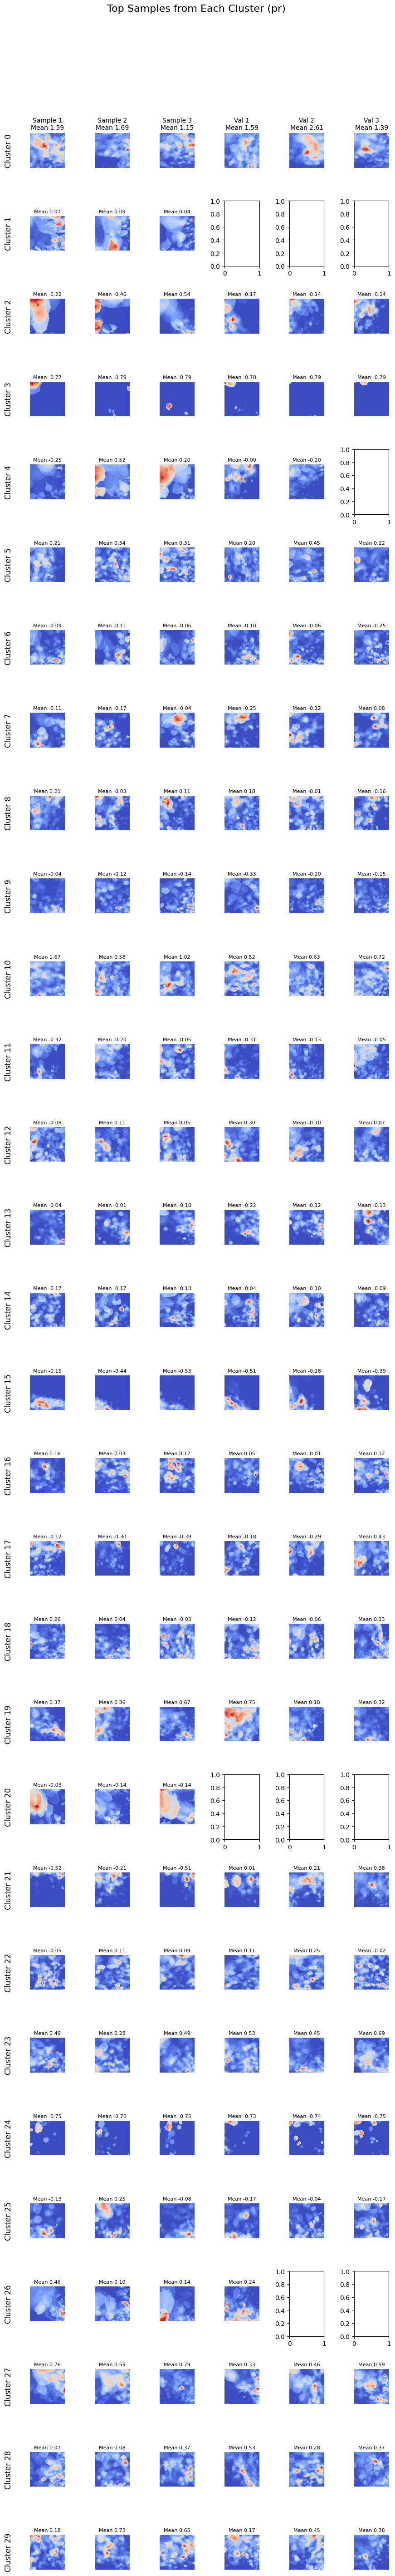

In [ ]:
Top = 3

max_val, max_idx = torch.max(F, dim=1) # Obtém os valores máximos e seus índices
df = pd.DataFrame({"max_idx": max_idx.cpu(), "max_val": max_val.cpu()})

if VALIDATION:
    max_val, max_idx = torch.max(F_val, dim=1)
    df_val = pd.DataFrame({"max_idx": max_idx.cpu(), "max_val": max_val.cpu()})
    fig, axes = plt.subplots(params['criterion']['num_proto'], Top * 2, figsize=(Top * 3, params['criterion']['num_proto'] * 2)) 
    
else:
    fig, axes = plt.subplots(params['criterion']['num_proto'], Top, figsize=(Top , params['criterion']['num_proto'])) 

fig.suptitle("Top Samples from Each Cluster (pr)", fontsize=16) # Título geral da figura

for i in range(params['criterion']['num_proto']):
    top_samples = df[df["max_idx"] == i].nlargest(Top, "max_val")

    for j, im_index in enumerate(top_samples.index):
        image_data = unsupervised_loader.dataset[im_index][0]

        ax_tmin = axes[i, j]
        ax_tmin.imshow(image_data[0], cmap='coolwarm')
        ax_tmin.axis("off")
        if i == 0: # Adiciona título da coluna apenas na primeira linha
            ax_tmin.set_title(f"Sample {j+1}\nMean {image_data.mean().item():.2f}", fontsize=10)
        else:
            ax_tmin.set_title(f'Mean {image_data.mean().item():.2f}', fontsize=8, pad=5)

    if VALIDATION:
        top_samples = df_val[df_val ["max_idx"] == i].nlargest(Top, "max_val")

        for j, im_index in enumerate(top_samples.index):
            image_data = rand_transform(unsupervised_loader.dataset.validation_imgs[im_index])

            ax_tmin = axes[i, j+ Top]
            ax_tmin.imshow(image_data[0], cmap='coolwarm')
            ax_tmin.axis("off")
            if i == 0: # Adiciona título da coluna apenas na primeira linha
                ax_tmin.set_title(f"Val {j+1}\nMean {image_data.mean().item():.2f}", fontsize=10)
            else:
                ax_tmin.set_title(f'Mean {image_data.mean().item():.2f}', fontsize=8, pad=5)

        # Adicionar título para cada linha de cluster
    axes[i, 0].text(-0.5, 0.5, f"Cluster {i}", transform=axes[i, 0].transAxes,
                    fontsize=12, va='center', ha='right', rotation=90)


plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta o layout para evitar sobreposição, deixando espaço para o título geral
plt.show()

Plot groups distributions according to weather seasons  /patterns

In [ ]:
def get_season(date):
    month = date.month
    day = date.day

    # Verão: 21 ou 22 de dezembro a 20 ou 21 de março
    if (month == 12 and day >= 21) or \
       (month == 1 or month == 2) or \
       (month == 3 and day <= 20):
        return 'Verão'
    # Outono: 20 ou 21 de março a 20 ou 21 de junho
    elif (month == 3 and day >= 21) or \
         (month == 4 or month == 5) or \
         (month == 6 and day <= 20):
        return 'Outono'
    # Inverno: 20 ou 21 de junho a 22 ou 23 de setembro
    elif (month == 6 and day >= 21) or \
         (month == 7 or month == 8) or \
         (month == 9 and day <= 22):
        return 'Inverno'
    # Primavera: 22 ou 23 de setembro a 20 ou 21 de dezembro
    else: # (month == 9 and day >= 23) or (month == 10 or month == 11) or (month == 12 and day <= 20)
        return 'Primavera'


df.index=pd.to_datetime(unsupervised_loader.dataset.time)
# Aplique a função para criar uma nova coluna 'season'
df['season'] = df.index.to_series().apply(get_season)


ValueError: Length mismatch: Expected axis has 22358 elements, new values have 23090 elements

In [ ]:
season_cluster_distribution = pd.crosstab(df['season'], df['max_idx'])

In [ ]:
season_cluster_distribution

max_idx,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
season,,,,,,,,,,,,,,,,,,,,,
Inverno,0,4,40,3891,1,0,16,22,0,5,...,2,15,0,1,1416,14,9,0,0,0
Outono,9,87,151,1295,62,24,120,155,44,77,...,43,274,29,8,2258,27,28,17,26,20
Primavera,61,173,200,77,84,88,265,256,40,254,...,127,258,73,122,1276,195,165,106,114,72
Verão,203,149,191,2,226,180,407,282,208,222,...,244,79,186,162,516,89,163,159,137,199


In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.countplot(data=df, x='season', hue='max_idx', order=season_order, palette='viridis')
plt.title('Contagem de Clusters por Estação do Ano no Brasil')
plt.xlabel('Estação do Ano')
plt.ylabel('Contagem')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster Label')
plt.tight_layout()
plt.show()


NameError: name 'season_order' is not defined

<Figure size 1200x700 with 0 Axes>

In [ ]:
# https://www.climate.gov/news-features/understanding-climate/climate-variability-oceanic-nino-index
oni_index = pd.read_excel('data/oni_index.xlsx')
oni_index.set_index('Year', inplace=True)
oni_index.columns.name='Month'
oni_index.columns = range(1,13)
oni_index= oni_index.unstack().to_frame('ONI')
oni_index['date_period'] = pd.to_datetime(oni_index.index.map(lambda x: f"{x[1]}-{x[0]}-01")).to_period('M')
oni_index.set_index('date_period', inplace=True)

oni_index =oni_index[oni_index.index.year>=1961]

oni_index.loc[oni_index['ONI'] > 0.5,'Label'] = 'El Niño'
oni_index.loc[oni_index['ONI'] < -0.5,'Label'] = 'La Niña'
oni_index.loc[oni_index['ONI'].between(-0.5, 0.5), 'Label'] = 'Neutro'

In [ ]:
df['period']= df.index.to_period('M')
df = df.merge(oni_index[['Label']], left_on='period', right_index=True, how='left')
df.head()

,max_idx,max_val,season,period,Label
1961-01-01,52,0.912607,Verão,1961-01,Neutro
1961-01-02,10,0.886604,Verão,1961-01,Neutro
1961-01-03,52,0.927949,Verão,1961-01,Neutro
1961-01-04,51,0.962296,Verão,1961-01,Neutro
1961-01-05,52,0.846989,Verão,1961-01,Neutro


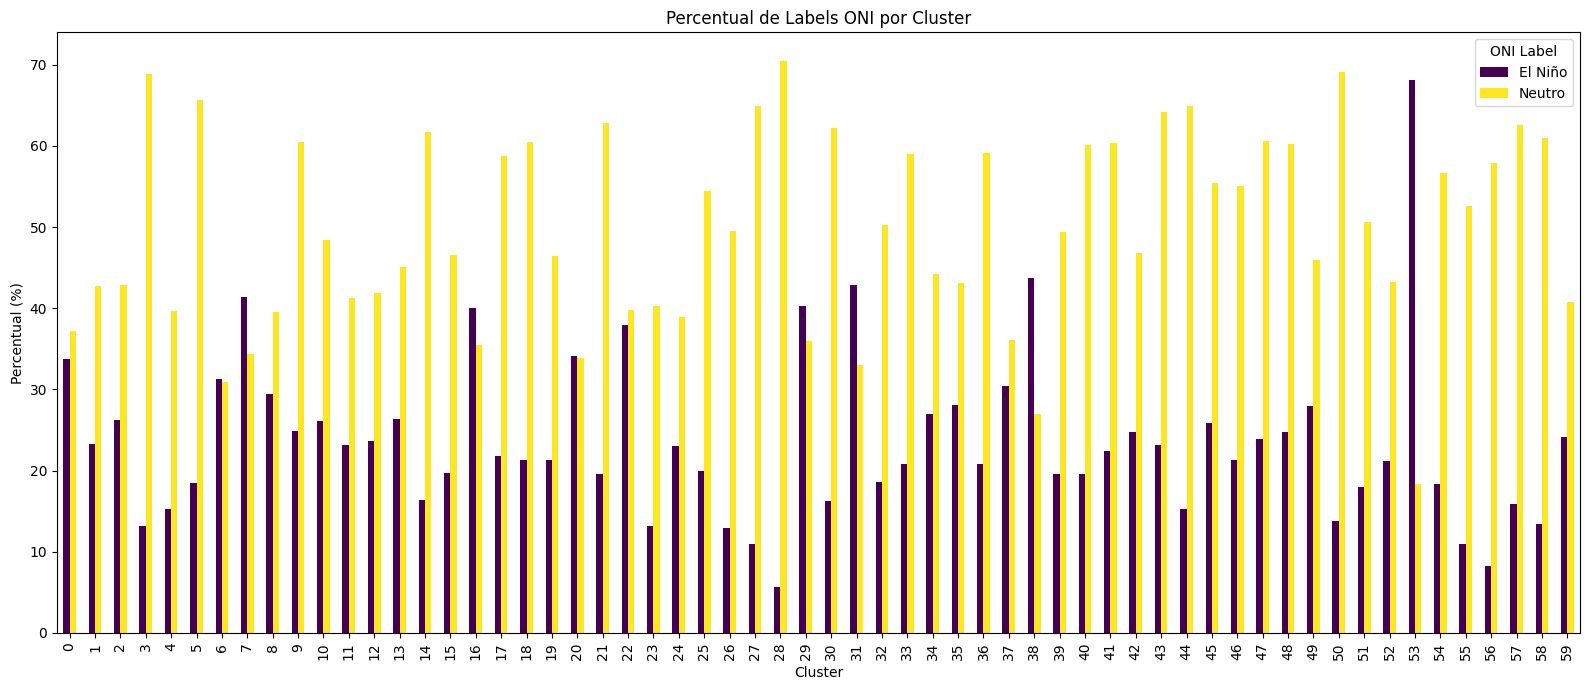

In [ ]:
#bar plot 
#max_idx vs Label
# Calculate percentual count for each label within each cluster
percent_df = (
    df.groupby(['max_idx', 'Label'])
    .size()
    .groupby(level=0)
    .apply(lambda x: 100 * x / x.sum())
    .unstack(fill_value=0)
    .droplevel(0)
)



# # Plot
percent_df.drop(columns=['La Niña']).plot(kind='bar', stacked=False, figsize=(16, 7), colormap='viridis')
plt.ylabel('Percentual (%)')
plt.xlabel('Cluster')
plt.title('Percentual de Labels ONI por Cluster')
plt.legend(title='ONI Label')
plt.tight_layout()
plt.show()


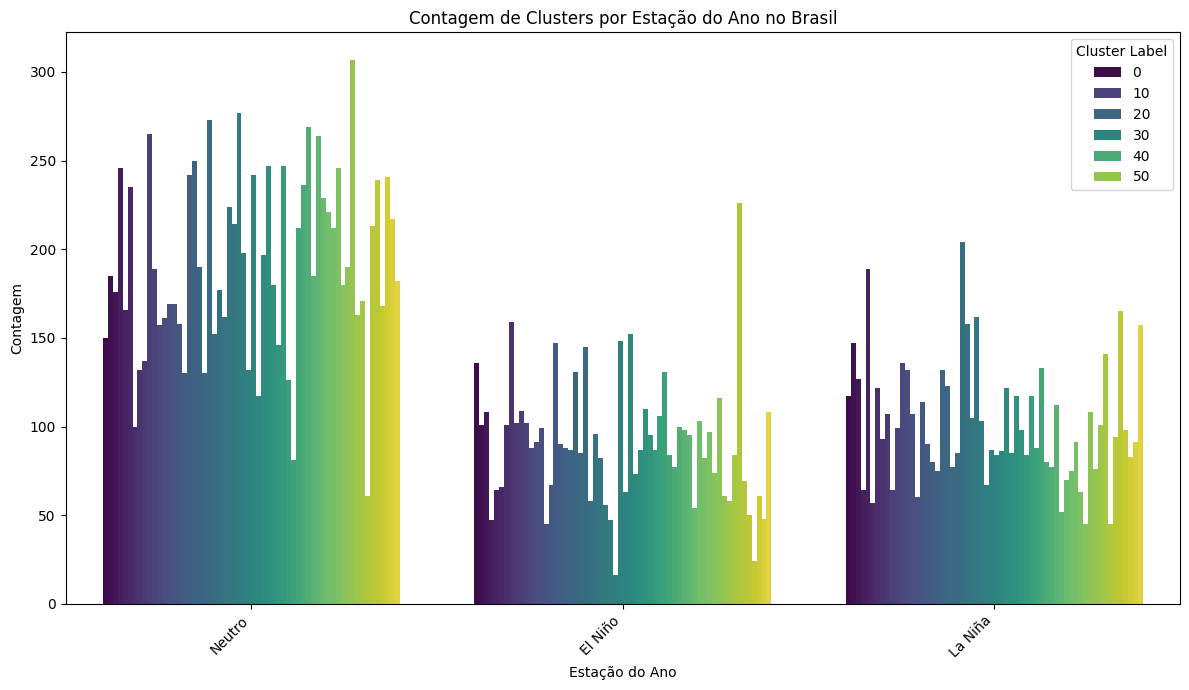

In [ ]:

plt.figure(figsize=(12, 7))
sns.countplot(data=df, x='Label', hue='max_idx', palette='viridis')
plt.title('Contagem de Clusters por Estação do Ano no Brasil')
plt.xlabel('Estação do Ano')
plt.ylabel('Contagem')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster Label')
plt.tight_layout()
plt.show()
